In [1]:
from nba_api.stats.endpoints import commonplayerinfo
from nba_api.stats.endpoints._base import Endpoint
from nba_api.stats.library.http import NBAStatsHTTP
from nba_api.stats.endpoints import playerdashboardbyteamperformance
from nba_api.stats.endpoints import leaguedashplayerstats
from nba_api.stats.endpoints import teamdashboardbyteamperformance
from nba_api.stats.endpoints import playerdashboardbylastngames
from nba_api.stats.endpoints import playerdashboardbyyearoveryear
from nba_api.stats.endpoints import teamdashboardbylastngames
from nba_api.stats.endpoints import teamplayerdashboard
from nba_api.stats.endpoints import commonplayerinfo
from nba_api.stats.static import teams
from nba_api.stats.static import players
import pandas as pd
import inspect
import numpy as np
import csv
import sys

import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

headers = { 'Host': 'stats.nba.com', 'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:61.0) Gecko/20100101 Firefox/61.0', 'Accept': 'application/json, text/plain, /', 'Accept-Language': 'en-US,en;q=0.5', 'Referer': 'https://stats.nba.com/', 'Accept-Encoding': 'gzip, deflate, br', 'Connection': 'keep-alive', }

In [2]:
#Enter Team1

team1_input = input('Enter team 1: ')

print(team1_input)

team1 = teams.find_teams_by_full_name(team1_input)[0]['id']

team1_dashboard_adv = teamdashboardbylastngames.TeamDashboardByLastNGames(team_id=team1, season='2019-20', 
                                                                    measure_type_detailed_defense='Advanced', 
                                                                        last_n_games=5, headers=headers)

team1_headers = team1_dashboard_adv.overall_team_dashboard.get_dict().get('headers')
team1_data = team1_dashboard_adv.overall_team_dashboard.get_dict().get('data')[0]

print(team1, '\n', team1_headers[7], team1_data[7], '\n', 
      team1_headers[8], team1_data[8], '\n',
      team1_headers[9], team1_data[9], '\n', 
      team1_headers[10], team1_data[10])

E_OFF1_RATING = team1_data[7]
OFF1_RATING = team1_data[8]
E_DEF1_RATING = team1_data[9]
DEF1_RATING = team1_data[10]

Enter team 1: Nets
Nets
1610612751 
 E_OFF_RATING 109.0 
 OFF_RATING 110.9 
 E_DEF_RATING 104.1 
 DEF_RATING 107.3


In [3]:
#Enter Team2
team2_input = input('Enter team 2: ')
print(team2_input)

team2 = teams.find_teams_by_full_name(team2_input)[0]['id']

team2_dashboard_adv = teamdashboardbylastngames.TeamDashboardByLastNGames(team_id=team2, season='2019-20', 
                                                                    measure_type_detailed_defense='Advanced', 
                                                                        last_n_games=5, headers=headers)

team2_headers = team2_dashboard_adv.overall_team_dashboard.get_dict().get('headers')
team2_data = team2_dashboard_adv.overall_team_dashboard.get_dict().get('data')[0]

print(team2, '\n', team2_headers[7], team2_data[7], '\n', 
      team2_headers[8], team2_data[8], '\n',
      team2_headers[9], team2_data[9], '\n', 
      team2_headers[10], team2_data[10])

E_OFF2_RATING = team2_data[7]
OFF2_RATING = team2_data[8]
E_DEF2_RATING = team2_data[9]
DEF2_RATING = team2_data[10]

Enter team 2: Celtics
Celtics
1610612738 
 E_OFF_RATING 102.7 
 OFF_RATING 105.4 
 E_DEF_RATING 102.4 
 DEF_RATING 105.2


In [4]:
#Load Rosters
roster1 = teamplayerdashboard.TeamPlayerDashboard(team_id=team1, last_n_games=1, 
                                                  season='2019-20', headers=headers).get_dict()
roster2 = teamplayerdashboard.TeamPlayerDashboard(team_id=team2, last_n_games=1, 
                                                  season='2019-20', headers=headers).get_dict()

team1_roster_lastn = []
team1_roster_id = []
team2_roster_lastn = []
team2_roster_id = []

for n in roster1['resultSets'][1]['rowSet']:
    print(n[2], 'GP:', n[3], 'id:', n[1], 'Min', n[7])
    team1_roster_lastn.append(n[2])
    team1_roster_id.append(n[1])

for n in roster2['resultSets'][1]['rowSet']:
    print(n[2], 'GP:', n[3], 'id:', n[1], 'Min', n[7])
    team2_roster_lastn.append(n[2])
    team2_roster_id.append(n[1])
    
print(team1_roster_lastn, '\n',
     team2_roster_lastn)

DeAndre Jordan GP: 1 id: 201599 Min 22.616666666666667
Dzanan Musa GP: 1 id: 1629058 Min 16.756666666666668
Garrett Temple GP: 1 id: 202066 Min 37.36666666666667
Iman Shumpert GP: 1 id: 202697 Min 18.715
Jarrett Allen GP: 1 id: 1628386 Min 25.291666666666668
Joe Harris GP: 1 id: 203925 Min 33.86833333333333
Spencer Dinwiddie GP: 1 id: 203915 Min 35.10166666666667
Taurean Prince GP: 1 id: 1627752 Min 33.251666666666665
Theo Pinson GP: 1 id: 1629033 Min 17.031666666666666
Brad Wanamaker GP: 1 id: 202954 Min 18.316666666666666
Carsen Edwards GP: 1 id: 1629035 Min 13.6
Daniel Theis GP: 1 id: 1628464 Min 6.933333333333334
Enes Kanter GP: 1 id: 202683 Min 20.85
Grant Williams GP: 1 id: 1629684 Min 8.65
Javonte Green GP: 1 id: 1629750 Min 3.683333333333333
Jaylen Brown GP: 1 id: 1627759 Min 34.001666666666665
Jayson Tatum GP: 1 id: 1628369 Min 37.04833333333333
Kemba Walker GP: 1 id: 202689 Min 31.533333333333335
Marcus Smart GP: 1 id: 203935 Min 32.55
Robert Williams III GP: 1 id: 1629057 Mi

In [5]:
#Individual Off and Def Ratings
    
team1_players_off = []
team1_players_def = []
team2_players_off = []
team2_players_def = []

roster1_calc = []
roster2_calc = []
roster1_calc_id = []
roster2_calc_id = []
roster1_pos = []
roster2_pos = []

player_info_off = leaguedashplayerstats.LeagueDashPlayerStats(last_n_games=5, season='2019-20', 
                                                              measure_type_detailed_defense='Advanced')

player_off_headers = player_info_off.league_dash_player_stats.get_dict().get('headers')
player_off_data = player_info_off.league_dash_player_stats.get_dict().get('data')

for p in team1_roster_lastn:
    for n in player_off_data:
        if p in n:
            print(n[1], '\n', 'Min', n[9], 
                  'E_Off_Rating', n[10], 'E_Def_Rating', n[13])
            if n[9] > 10:
                roster1_calc.append(n[1])
                team1_players_off.append(n[10])
                team1_players_def.append(n[13])
                roster1_calc_id.append(n[0])

for p in team2_roster_lastn:
    for n in player_off_data:
        if p in n:
            print(n[1], '\n', 'Min', n[9], 
                  'E_Off_Rating', n[10], 'E_Def_Rating', n[13])
            if n[9] > 10:
                roster2_calc.append(n[1])
                team2_players_off.append(n[10])
                team2_players_def.append(n[13])
                roster2_calc_id.append(n[0])
print(roster2_calc)

#Player Position

for pid in roster1_calc_id:
    player_pos_info = commonplayerinfo.CommonPlayerInfo(player_id=pid, headers=headers)
    player_data_calc = player_pos_info.common_player_info.get_dict().get('data')[0]
    print(player_data_calc[3], player_data_calc[0], player_data_calc[14])
    roster1_pos.append(player_data_calc[14])

for pid in roster2_calc_id:
    player_pos_info = commonplayerinfo.CommonPlayerInfo(player_id=pid, headers=headers)
    player_data_calc = player_pos_info.common_player_info.get_dict().get('data')[0]    
    print(player_data_calc[3], player_data_calc[0], player_data_calc[14])
    roster2_pos.append(player_data_calc[14])

data1 = {'Name':roster1_calc, 'OffR':team1_players_off, 'DefR':team1_players_def, 'Pos': roster1_pos}
data2 = {'Name':roster2_calc, 'OffR':team2_players_off, 'DefR':team2_players_def, 'Pos': roster2_pos}

DeAndre Jordan 
 Min 19.4 E_Off_Rating 104.2 E_Def_Rating 101.1
Dzanan Musa 
 Min 19.4 E_Off_Rating 102.8 E_Def_Rating 105.7
Garrett Temple 
 Min 35.0 E_Off_Rating 110.6 E_Def_Rating 105.4
Iman Shumpert 
 Min 20.1 E_Off_Rating 98.4 E_Def_Rating 98.0
Jarrett Allen 
 Min 29.3 E_Off_Rating 113.9 E_Def_Rating 103.2
Joe Harris 
 Min 30.2 E_Off_Rating 116.8 E_Def_Rating 104.9
Spencer Dinwiddie 
 Min 32.1 E_Off_Rating 112.9 E_Def_Rating 105.5
Taurean Prince 
 Min 30.9 E_Off_Rating 114.3 E_Def_Rating 104.5
Theo Pinson 
 Min 18.7 E_Off_Rating 102.8 E_Def_Rating 104.5
Brad Wanamaker 
 Min 22.6 E_Off_Rating 102.6 E_Def_Rating 94.5
Carsen Edwards 
 Min 10.2 E_Off_Rating 81.3 E_Def_Rating 96.6
Daniel Theis 
 Min 20.7 E_Off_Rating 94.4 E_Def_Rating 106.0
Enes Kanter 
 Min 17.2 E_Off_Rating 111.3 E_Def_Rating 97.9
Grant Williams 
 Min 11.6 E_Off_Rating 101.1 E_Def_Rating 94.1
Javonte Green 
 Min 4.8 E_Off_Rating 99.8 E_Def_Rating 68.9
Jaylen Brown 
 Min 35.3 E_Off_Rating 102.4 E_Def_Rating 102.5
Jays

In [6]:
pdf1 = pd.DataFrame(data1, columns = ['Name', 'OffR', 'DefR', 'Pos'])  
pdf2 = pd.DataFrame(data2, columns = ['Name', 'OffR', 'DefR', 'Pos'])

In [13]:
rdf = pd.read_csv("regression_list.csv", sep=r'\t', engine='python') 
rdf.T1_OR5

0       110.22
1       110.00
2       112.46
3       110.68
4       111.00
5       108.94
6       106.50
7       106.36
8       109.04
9       111.58
10      111.34
11      114.18
12      113.92
13      111.44
14      109.02
15      111.64
16      114.06
17      114.32
18      114.58
19      111.14
20      109.04
21      108.66
22      109.80
23      106.50
24      114.34
25      116.86
26      116.56
27      113.68
28      117.66
29      112.82
         ...  
2280    108.04
2281    114.84
2282    113.12
2283    110.22
2284    111.96
2285    112.08
2286    110.44
2287    109.16
2288    107.68
2289    104.60
2290    106.66
2291    106.76
2292    106.90
2293    112.16
2294    113.10
2295    108.26
2296    108.60
2297    111.54
2298    110.70
2299    111.52
2300    111.12
2301    109.62
2302    106.64
2303    103.90
2304    101.60
2305    102.16
2306    102.76
2307    102.62
2308    105.00
2309    107.06
Name: T1_OR5, Length: 2310, dtype: float64

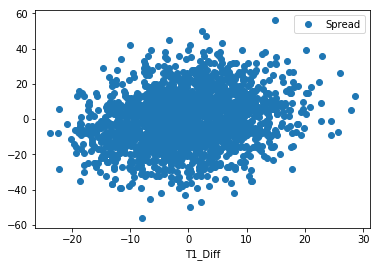

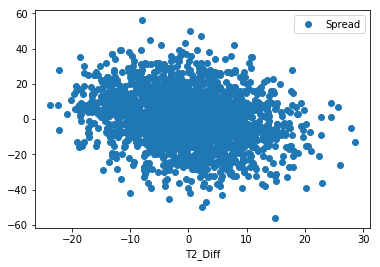

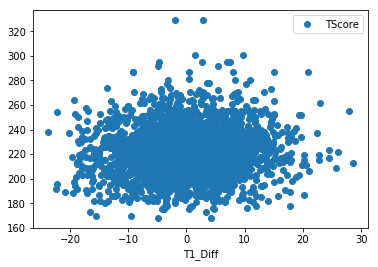

In [15]:
rdf = pd.read_csv("regression_list.csv", sep=r'\t', engine='python') 

rdf['T1_Diff'] = rdf.T1_OR5 - rdf.T1_DR5
rdf['T2_Diff'] = rdf.T2_OR5 - rdf.T2_DR5

rdf.T1_OR5 = pd.to_numeric(rdf.T1_OR5)
rdf.T1_DR5 = pd.to_numeric(rdf.T1_DR5)
rdf.T2_OR5 = pd.to_numeric(rdf.T2_OR5)
rdf.T2_DR5 = pd.to_numeric(rdf.T2_DR5)

rdf.plot(x='T1_Diff', y='Spread', style='o')  
rdf.plot(x='T2_Diff', y='Spread', style='o') 
rdf.plot(x='T1_Diff', y='TScore', style='o') 


In [16]:
from pandas import DataFrame
from sklearn import linear_model
import statsmodels.api as sm

X = rdf[['T1_OR5','T1_DR5', 'T2_OR5', 'T2_DR5']]
# X = rdf[['T1_Diff', 'T2_Diff']]

Y = rdf['Spread']
Y2 = rdf['TScore']

regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

regr2 = linear_model.LinearRegression()
regr2.fit(X, Y2)

print('Intecept_Score: \n', regr2.intercept_)
print('Coefficients_Score: \n', regr2.coef_)


/Users/stan/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Intercept: 
 0.1968372047350489
Coefficients: 
 [ 0.42950031 -0.40077189 -0.43303045  0.40262237]
Intecept_Score: 
 96.94754180172698
Coefficients_Score: 
 [0.42136938 0.15357508 0.41373199 0.15386099]


/Users/stan/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


In [17]:
# prediction with sklearn
#https://stats.nba.com/team/1610612763/advanced/?Season=2019-20&SeasonType=Regular%20Season&Split=lastn

New_T1_OR5 = E_OFF1_RATING
New_T1_DR5 = E_DEF1_RATING
New_T1_Diff = (E_OFF1_RATING - E_DEF1_RATING)

New_T2_OR5 = E_OFF2_RATING
New_T2_DR5 = E_DEF2_RATING
New_T2_Diff = (E_OFF2_RATING - E_DEF2_RATING)

print('Predicted Spread: \n', regr.predict([[New_T1_OR5 ,New_T1_DR5, 
                                             New_T2_OR5, New_T2_OR5]]))
print('Predicted Over/Under: \n', regr2.predict([[New_T1_OR5 ,New_T1_DR5,
                                                  New_T2_OR5, New_T2_OR5 ]]))

# print(New_T1_Diff, New_T2_Diff)
# print('Predicted Spread: \n', regr.predict([[New_T1_Diff, New_T2_Diff]]))
# print('Predicted Over/Under: \n', regr2.predict([[New_T1_Diff, New_T2_Diff]]))



# with statsmodels
X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)

Predicted Spread: 
 [2.1691082]
Predicted Over/Under: 
 [217.1557705]
                            OLS Regression Results                            
Dep. Variable:                 Spread   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     64.67
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           6.76e-52
Time:                        15:53:50   Log-Likelihood:                -9365.1
No. Observations:                2310   AIC:                         1.874e+04
Df Residuals:                    2305   BIC:                         1.877e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

In [18]:
# prediction with sklearn
from pandas import DataFrame
from sklearn import linear_model
import statsmodels.api as sm

tpt_total = 0

for n in range(len(data1['Name'])):
    ppt_total = 0
    count = 0
    print('=== \n', data1['Name'][n], data1['OffR'][n], data1['DefR'][n], data1['Pos'][n])
    for p in range(len(data2['Name'])):
        if data1['Pos'][n] == data2['Pos'][p]:
            print(data2['Name'][p])
            print('d1or', data1['OffR'][n], 'd2dr', data2['DefR'][p])
            New_T1_OR5 = data1['OffR'][n]
            New_T1_DR5 = data1['DefR'][n]
            New_T2_OR5 = data2['OffR'][p]
            New_T2_DR5 = data2['DefR'][p]

            print('Predicted Spread: \n', regr.predict([[New_T1_OR5 ,New_T1_DR5, New_T2_OR5, New_T2_OR5 ]]))
    #             print('Predicted Over/Under: \n', regr2.predict([[New_T1_OR5 ,New_T1_DR5, New_T2_OR5, New_T2_OR5 ]])) 
            spread = regr.predict([[New_T1_OR5 ,New_T1_DR5, New_T2_OR5, New_T2_OR5 ]])
            ppt_total += spread
            tpt_total += spread
            
    print('player_pt_total', ppt_total, '\n')

print('team_pt_total', tpt_total)
            
#     # with statsmodels
#     X = sm.add_constant(X) # adding a constant

#     model = sm.OLS(Y, X).fit()
#     predictions = model.predict(X) 

#     print_model = model.summary()
#     print(print_model)

=== 
 DeAndre Jordan 104.2 101.1 Center
Enes Kanter
d1or 104.2 d2dr 97.9
Predicted Spread: 
 [1.04831294]
player_pt_total [1.04831294] 

=== 
 Dzanan Musa 102.8 105.7 Guard-Forward
Jaylen Brown
d1or 102.8 d2dr 102.5
Predicted Spread: 
 [-1.12590631]
player_pt_total [-1.12590631] 

=== 
 Garrett Temple 110.6 105.4 Guard-Forward
Jaylen Brown
d1or 110.6 d2dr 102.5
Predicted Spread: 
 [2.34442767]
player_pt_total [2.34442767] 

=== 
 Iman Shumpert 98.4 98.0 Guard
Brad Wanamaker
d1or 98.4 d2dr 94.5
Predicted Spread: 
 [0.06415424]
Carsen Edwards
d1or 98.4 d2dr 96.6
Predicted Spread: 
 [0.71184624]
Kemba Walker
d1or 98.4 d2dr 111.3
Predicted Spread: 
 [0.06415424]
Marcus Smart
d1or 98.4 d2dr 108.3
Predicted Spread: 
 [-0.03011079]
player_pt_total [0.81004394] 

=== 
 Jarrett Allen 113.9 103.2 Center
Enes Kanter
d1or 113.9 d2dr 97.9
Predicted Spread: 
 [4.37284497]
player_pt_total [4.37284497] 

=== 
 Joe Harris 116.8 104.9 Guard-Forward
Jaylen Brown
d1or 116.8 d2dr 102.5
Predicted Spread: 
 

In [19]:
#Theory: If second game of back-to-back is a road game, odds of winning decrease 7-8%, multiply ratings by 0.93.

In [ ]:
data = pd.read_csv("NBA Merged Sheets - Sheet2.csv") 
data_t = pd.read_csv("team_stats_basic_2018-19.csv")
df = pd.read_csv("team 2018-19.csv") 

teams = ['ATL', 'IND', 'MIL', 'ORL', 'PHI', 'SAS', 'POR', 'NOP', 'UTA', 'HOU', 'BOS', 
         'MEM', 'BKN', 'MIA', 'CHI', 'MIN', 'PHX', 'DET', 'NYK', 'LAL', 'CHA', 'TOR', 
         'WAS', 'SAC', 'LAC', 'OKC', 'CLE', 'DAL', 'DEN', 'GSW']

In [ ]:
def regression(team):
    
    with open('regression_list.csv', 'a', newline='') as csvFile:
        writer = csv.writer(csvFile)
        headers = ['Team1','T1_OR5', 'T1_DR5', 'Team2', 'T2_OR5', 'T2_DR5', 'Spread', 'TScore']
        writer.writerow(headers)
    csvFile.close() 
    
    team2 = []
    date = []
    score = []
    opp = []
    
    df2 = df[['Team', 'Matchup', 'Date', 'OffRtg', 'DefRtg', 'ASTRatio', 'PACE']]
    df2 = df[df['Team'] == team1]

    team2 = df2['Matchup']

    for row in team2:
        opp.append(row.replace(team1+'vs.', '').replace(team1+'@', ''))

    df2['Opp'] = opp

    team1_off_avg = 0
    team1_def_avg = 0
    team2_off_avg = 0
    team2_def_avg = 0
    totalscore = 0

    for index, row in df2.head(n=77).iterrows(): 
        whole_row = []
        team2 = row['Opp']
        date = row['Date']
        df3 = df[df['Team'] == team2]

        score = data.loc[(data['DATE']==date) & (data['TEAM']==team1)]
        score = score.iloc[0]
        score = (score["team_pts"], score['team_plus_minus'])
        print('===', row['Team'], row['OffRtg'], row['DefRtg'], 
              row['Date'], row['Opp'], score, "===") 
                
        print(row['Team'], 'Last5_Off', row['Last5_Off'], 'Last5_Def', row['Last5_Def'])
        whole_row.append(row['Team'])
        whole_row.append(row['Last5_Off'])
        whole_row.append(row['Last5_Def'])

        df3 = df3.loc[df3['Date'] == date]
        for index, row in df3.iterrows():
            print(row['Team'], 'Last5_Off', row['Last5_Off'], 'Last5_Def', row['Last5_Def'], '\n')
            whole_row.append(row['Team'])
            whole_row.append(row['Last5_Off'])
            whole_row.append(row['Last5_Def'])
            whole_row.append(score[1])
            whole_row.append(score[0]-score[1]+score[0])
            
            with open('regression_list.csv', 'a') as csvFile:
                writer = csv.writer(csvFile)
                writer.writerow(whole_row)
            csvFile.close() 

In [ ]:
for team in teams:
    regression(team)

In [20]:
#Individual Off_PER 

def off_per_calculator(player, player_id, team):
    
    PER_MP = 0
    agg_aPERmin = 0
    agg_min = 0
    p_name = []
    
    teamdashboard = teamdashboardbylastngames.TeamDashboardByLastNGames(team_id=team, season='2019-20', 
                                                                        last_n_games=5, headers=headers)
    teamdashboard_adv = teamdashboardbylastngames.TeamDashboardByLastNGames(team_id=team, season='2019-20', 
                                                                    measure_type_detailed_defense='Advanced', 
                                                                        last_n_games=5, headers=headers)

    ##last n games
    team_headers_basic = teamdashboard.overall_team_dashboard.get_dict().get('headers')
    team_data_basic = teamdashboard.overall_team_dashboard.get_dict().get('data')[0]
    team_headers = teamdashboard_adv.overall_team_dashboard.get_dict().get('headers')
    team_data = teamdashboard_adv.overall_team_dashboard.get_dict().get('data')[0]
    
    for n in player_id:    
        p_info = playerdashboardbylastngames.PlayerDashboardByLastNGames(player_id=n, season='2019-20',
                                                                        last_n_games=5, headers=headers)
        if players.find_player_by_id(n):
            p_name = players.find_player_by_id(player_id=n)['full_name']
        player_headers = p_info.overall_player_dashboard.get_dict().get('headers')
        player_data = p_info.overall_player_dashboard.get_dict().get('data')[0]
 
    #####PER player stats####
        MP = player_data[6]
        ThrP = player_data[10] 
        AST = player_data[19]
        TOV = player_data[20]
        FGA = player_data[8]
        FG = player_data[7] + player_data[10] 
        FTA = player_data[14]
        FT = player_data[13]
        TRB = player_data[18]
        ORB = player_data[16]
        STL = player_data[21]
        BLK = player_data[22]
        PF = player_data[24]

    ###PER league stats (2018-19)###
        lg_AST = 24.6
        lg_FG = 41.1
        lg_PTS = 111.2
        lg_FGA = 89.2
        lg_FT = 17.7
        lg_FTA = 23.1
        lg_TRB = 45.2
        lg_ORB = 10.3
        lg_TOV = 14.1
        lg_PF = 20.9
        lg_pace = 100
        
    ###PER team stats###
        team_AST = team_data_basic[19]
        team_FG = team_data_basic[7]+team_data_basic[10]
        team_pace = team_data[23] 
       
        factor = (2/3) - (0.5*(lg_AST/lg_FG)) / (2*(lg_FG/lg_FT)) 
        VOP = lg_PTS / (lg_FGA-lg_ORB+lg_TOV+0.44*lg_FTA) 
        DRB_perc = (lg_TRB -lg_ORB) / lg_TRB

    ####PER Calculation####                    
        PER_calc_player = (1 / MP) * ( ThrP + (2/3) * AST 
                                      + (2 - factor * (team_AST / team_FG)) * FG 
                                      + (FT *0.5 * (1 + (1 - (team_AST / team_FG)) + (2/3) * (team_AST / team_FG)))
                                      - VOP * TOV - VOP * DRB_perc * (FGA - FG)
                                      - VOP * 0.44 * (0.44 + (0.56 * DRB_perc)) * (FTA - FT)
                                      + VOP * (1 - DRB_perc) * (TRB - ORB) + VOP * DRB_perc * ORB 
                                      + VOP * STL + VOP * DRB_perc * BLK - PF 
                                      * ((lg_FT / lg_PF) - 0.44 * (lg_FTA / lg_PF) * VOP) )

        adj_PER_calc_player = PER_calc_player * (lg_pace /team_pace) *54
        aPER_min = adj_PER_calc_player * MP
        agg_aPERmin += aPER_min
        agg_min += MP
        
        print(p_name, n, 'Min', round(MP, 2), 
              'adj_PER_calc_player', round(adj_PER_calc_player, 2), 
              'aPER_min', round(aPER_min, 2))

    print('agg_aPERmin', round(agg_aPERmin,2), 
          'avg_aPER_min', round(agg_aPERmin/agg_min, 2), '\n')

In [21]:
off_per_calculator(team1_roster_lastn, team1_roster_id, team1)
off_per_calculator(team2_roster_lastn, team2_roster_id, team2)

DeAndre Jordan 201599 Min 58.13 adj_PER_calc_player 24.84 aPER_min 1443.83
Dzanan Musa 1629058 Min 96.82 adj_PER_calc_player 10.57 aPER_min 1022.99
Garrett Temple 202066 Min 175.04 adj_PER_calc_player 31.4 aPER_min 5495.87
Iman Shumpert 202697 Min 100.59 adj_PER_calc_player 18.81 aPER_min 1892.0
Jarrett Allen 1628386 Min 146.28 adj_PER_calc_player 33.99 aPER_min 4971.86
Joe Harris 203925 Min 151.15 adj_PER_calc_player 39.01 aPER_min 5896.84
Spencer Dinwiddie 203915 Min 160.66 adj_PER_calc_player 40.25 aPER_min 6466.1
Taurean Prince 1627752 Min 154.41 adj_PER_calc_player 24.72 aPER_min 3817.1
Theo Pinson 1629033 Min 93.68 adj_PER_calc_player 2.98 aPER_min 278.93
agg_aPERmin 31285.53 avg_aPER_min 27.52 

Brad Wanamaker 202954 Min 112.9 adj_PER_calc_player 26.52 aPER_min 2993.83
Brad Wanamaker 1629035 Min 40.85 adj_PER_calc_player 17.86 aPER_min 729.38
Daniel Theis 1628464 Min 82.95 adj_PER_calc_player 23.67 aPER_min 1963.23
Enes Kanter 202683 Min 86.01 adj_PER_calc_player 31.19 aPER_min 

In [22]:
#Alt Player Def Rating

def def_per_calc(team_roster):
    agg_def_rating = 0
    agg_min = 0
    player_info_def = leaguedashplayerstats.LeagueDashPlayerStats(last_n_games=5, season='2019-20', 
                                                                      measure_type_detailed_defense='Defense')

    player_def_headers = player_info_def.league_dash_player_stats.get_dict().get('headers')
    player_def_data = player_info_def.league_dash_player_stats.get_dict().get('data')

#     print('headers:', player_def_headers)
        #print('data:', player_def_data)

    for p in team_roster:
        for n in player_def_data:
            if p in n:
                print(n[1], '\n', 'Def Rating', n[10], 'Min', n[9])
                agg_def_rating += (n[10]*n[9])
                agg_min += n[9]

    
    avg_def_rating = agg_def_rating/len(team_roster)
    avg_def_rating_min = agg_def_rating/agg_min

    print('avg_def_rating', avg_def_rating, 'agg_min', round(agg_min, 2)) 
    print('avg_def_rating_min', round(avg_def_rating_min, 2), '\n')

In [23]:
def_per_calc(team1_roster_lastn)
def_per_calc(team2_roster_lastn)

DeAndre Jordan 
 Def Rating 100.8 Min 58.13333333333333
Dzanan Musa 
 Def Rating 108.3 Min 96.82166666666667
Garrett Temple 
 Def Rating 106.3 Min 175.04166666666666
Iman Shumpert 
 Def Rating 98.6 Min 100.59166666666667
Jarrett Allen 
 Def Rating 106.6 Min 146.27833333333334
Joe Harris 
 Def Rating 108.4 Min 151.14666666666668
Spencer Dinwiddie 
 Def Rating 107.8 Min 160.66
Taurean Prince 
 Def Rating 107.5 Min 154.415
Theo Pinson 
 Def Rating 105.5 Min 93.67833333333333
avg_def_rating 13405.58751851852 agg_min 1136.77
avg_def_rating_min 106.13 

Brad Wanamaker 
 Def Rating 95.3 Min 112.9
Carsen Edwards 
 Def Rating 93.1 Min 40.85
Daniel Theis 
 Def Rating 105.6 Min 82.94666666666667
Enes Kanter 
 Def Rating 97.7 Min 86.01166666666667
Grant Williams 
 Def Rating 96.7 Min 58.141666666666666
Javonte Green 
 Def Rating 76.5 Min 14.478333333333333
Jaylen Brown 
 Def Rating 104.4 Min 176.43333333333334
Jayson Tatum 
 Def Rating 106.4 Min 179.40166666666667
Kemba Walker 
 Def Rating 112.4 M